<a href="https://colab.research.google.com/github/Hazem-Abdelsalam/ML-QDs-electronic-properties/blob/main/ML_GQDs_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Install, Import, Upload & Setup

In [ ]:
# Step 1: Install, Import, Upload & Setup
import os

# Install chemprop from GitHub if in Colab
if os.getenv("COLAB_RELEASE_TAG"):
    try:
        import chemprop
    except ImportError:
        !git clone https://github.com/chemprop/chemprop.git && cd chemprop && pip install . && cd ..
        !pip install rdkit-pypi --pre deepchem

# Import packages
from pathlib import Path
from lightning import pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint
import pandas as pd
import torch
import numpy as np
from google.colab import files
import re
from typing import List
from chemprop import data, featurizers, models, nn

# Set seed for reproducibility
pl.seed_everything(24, workers=True)



Cloning into 'chemprop'...
remote: Enumerating objects: 25475, done.
remote: Counting objects: 100% (222/222), done.
remote: Compressing objects: 100% (178/178), done.
remote: Total 25475 (delta 131), reused 44 (delta 44), pack-reused 25253 (from 3)
Receiving objects: 100% (25475/25475), 876.25 MiB | 25.61 MiB/s, done.
Resolving deltas: 100% (18254/18254), done.
Updating files: 100% (337/337), done.
Processing /content/chemprop
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.9/827.9 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

INFO: Seed set to 24
INFO:lightning.fabric.utilities.seed:Seed set to 24


24

##Upload and process CSV

In [ ]:
from google.colab import files
import pandas as pd
import re
from typing import List

def upload_and_combine_csvs(
    expected_base_names: List[str] = ['GQDs_SiCQDs_Data'],
    smiles_columns: List[str] = ['SMILES'],
    target_columns: List[List[str]] = [[ 'HOMO', 'LUMO']],
    name_column: str = 'Name',  # Column in the CSV containing unique molecule identifiers
    output_filename: str = 'combined_cleaned_results.csv'
) -> pd.DataFrame:

    print("Please upload your CSV file...")
    uploaded = files.upload()

    def find_matching_file(base_name):
        # Matches: base_name.csv, base_name (1).csv, etc., case-insensitive
        pattern = re.compile(fr'{re.escape(base_name)}(?:\s*\(\d+\))?\.csv$', re.IGNORECASE)
        for filename in uploaded.keys():
            if pattern.fullmatch(filename):
                return filename
        return None

    dfs = []
    for base_name, smi_col, tgt_cols in zip(expected_base_names, smiles_columns, target_columns):
        matched_file = find_matching_file(base_name)
        if not matched_file:
            available_files = "\n".join(uploaded.keys())
            raise FileNotFoundError(
                f"No file matching '{base_name}' found.\nAvailable files:\n{available_files}"
            )

        print(f"\n✅ Loading: {matched_file}")
        try:
            df = pd.read_csv(matched_file)

            # Rename SMILES and target columns to lowercase standard names
            df = df.rename(columns={smi_col: 'smiles'})
            for tgt_col in tgt_cols:
                df = df.rename(columns={tgt_col: tgt_col.lower()})

            # Ensure required columns exist
            required_cols = ['smiles', name_column] + [col.lower() for col in tgt_cols]
            missing_cols = [col for col in required_cols if col not in df.columns]
            if missing_cols:
                raise ValueError(f"Missing columns in {matched_file}: {missing_cols}")

            # Drop rows with missing values and keep only needed columns
            df = df[required_cols].dropna().copy()
            print(f"   → {len(df)} valid rows after cleaning")
            dfs.append(df)

        except Exception as e:
            raise RuntimeError(f"Error processing {matched_file}: {str(e)}")

    if len(dfs) == 0:
        raise ValueError("No valid data frames to combine.")

    # Combine all data
    combined_df = pd.concat(dfs, ignore_index=True)
    combined_df.to_csv(output_filename, index=False)

    print(f"\n🎉 Successfully combined data into '{output_filename}'")
    print(f"📊 Total combined rows: {len(combined_df)}")
    print(f"📋 Columns: {list(combined_df.columns)}")

    return combined_df


# === RUN THE FUNCTION ===
try:

    df_input = upload_and_combine_csvs(
        expected_base_names=['cleaned_data_for_retraining'],
        smiles_columns=['SMILES'],  # Assuming same column name in both
        target_columns=[[ 'HOMO', 'LUMO']],
        name_column='Name',  # Specify the "Name" column
        output_filename='combined_cleaned_results.csv'
    )

    # Extract data
    smis = df_input['smiles'].values
    names = df_input['Name'].values  # Extract the "Name" column
    ys_all = df_input[[ 'homo', 'lumo']].values

    # Display summary
    print("\n🔍 Preview of first 5 SMILES, Names, and targets:")
    print(df_input.head())

    print(f"\n🔢 Dataset Summary:")
    print(f"   Total SMILES: {len(smis)}")
    print(f"   Gap shape: {ys_all.shape}")
    print(f"   All targets (homo, lumo): {ys_all.shape}")

except Exception as e:
    print(f"❌ Error: {str(e)}")

Please upload your CSV file...


Saving GQDs_SiCQDs_Data.csv to GQDs_SiCQDs_Data.csv
❌ Error: No file matching 'cleaned_data_for_retraining' found.
Available files:
GQDs_SiCQDs_Data.csv


# Step 2: Data Preparation, Training & Prediction

In [ ]:
# Step 2: Data Preparation, Training & Prediction
from sklearn.model_selection import train_test_split

# Create MoleculeDatapoints (assuming ys_all is shape [N, 2] for homo, lumo)
all_data = [data.MoleculeDatapoint.from_smi(smi, y) for smi, y in zip(smis, ys_all)]
mols = [d.mol for d in all_data]

# Split: 80% train, 10% val, 10% test
train_indices, val_indices, test_indices = data.make_split_indices(mols, "random", (0.8, 0.1, 0.1))
train_data, val_data, test_data = data.split_data_by_indices(all_data, train_indices, val_indices, test_indices)

# Featurizer and Datasets
featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()
train_dset = data.MoleculeDataset(train_data[0], featurizer)
scaler = train_dset.normalize_targets()

val_dset = data.MoleculeDataset(val_data[0], featurizer)
val_dset.normalize_targets(scaler)

test_dset = data.MoleculeDataset(test_data[0], featurizer)
test_dset.normalize_targets(scaler)

# DataLoaders
num_workers = 4
train_loader = data.build_dataloader(train_dset, num_workers=num_workers, shuffle=True)
val_loader = data.build_dataloader(val_dset, num_workers=num_workers, shuffle=False)
test_loader = data.build_dataloader(test_dset, num_workers=num_workers, shuffle=False)

# Build MPNN Model — note: n_tasks=2 for homo and lumo
mp = nn.BondMessagePassing()
agg = nn.MeanAggregation()
output_transform = nn.UnscaleTransform.from_standard_scaler(scaler)
ffn = nn.RegressionFFN(output_transform=output_transform, n_tasks=2)  # ✅ Changed to 2
metric_list = [nn.metrics.RMSE(), nn.metrics.MAE(), nn.metrics.R2Score()]

mpnn = models.MPNN(mp, agg, ffn, batch_norm=True, metrics=metric_list)

# Trainer with checkpointing
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    mode="min",
    save_top_k=1,
    dirpath="checkpoints",
    filename="best-{epoch}-{val_loss:.2f}"
)

trainer = pl.Trainer(
    logger=False,
    enable_checkpointing=True,
    enable_progress_bar=True,
    accelerator="auto",
    devices=1,
    max_epochs=300,
    callbacks=[checkpoint_callback],
    deterministic=True
)

# Train
print("🚀 Starting training...")
trainer.fit(mpnn, train_loader, val_loader)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:751: Checkpoint directory /content/checkpoints exists and is not empty.
INFO: Loading `train_dataloader` to estimate number of stepping batches.
INFO:lightning.pytorch.utilities.rank_zero:Loading `train_datalo

🚀 Starting training...


INFO: 
  | Name            | Type               | Params | Mode 
---------------------------------------------------------------
0 | message_passing | BondMessagePassing | 227 K  | train
1 | agg             | MeanAggregation    | 0      | train
2 | bn              | BatchNorm1d        | 600    | train
3 | predictor       | RegressionFFN      | 90.9 K | train
4 | X_d_transform   | Identity           | 0      | train
5 | metrics         | ModuleList         | 0      | train
---------------------------------------------------------------
319 K     Trainable params
0         Non-trainable params
319 K     Total params
1.277     Total estimated model params size (MB)
26        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name            | Type               | Params | Mode 
---------------------------------------------------------------
0 | message_passing | BondMessagePassing | 227 K  | train
1 | agg             | MeanAggregation 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=300` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=300` reached.


# Step 3: Evaluate, Plot & Save Results

Predicting: |          | 0/? [00:00<?, ?it/s]

✅ Predictions saved to 'test_set_predictions_with_name.csv'


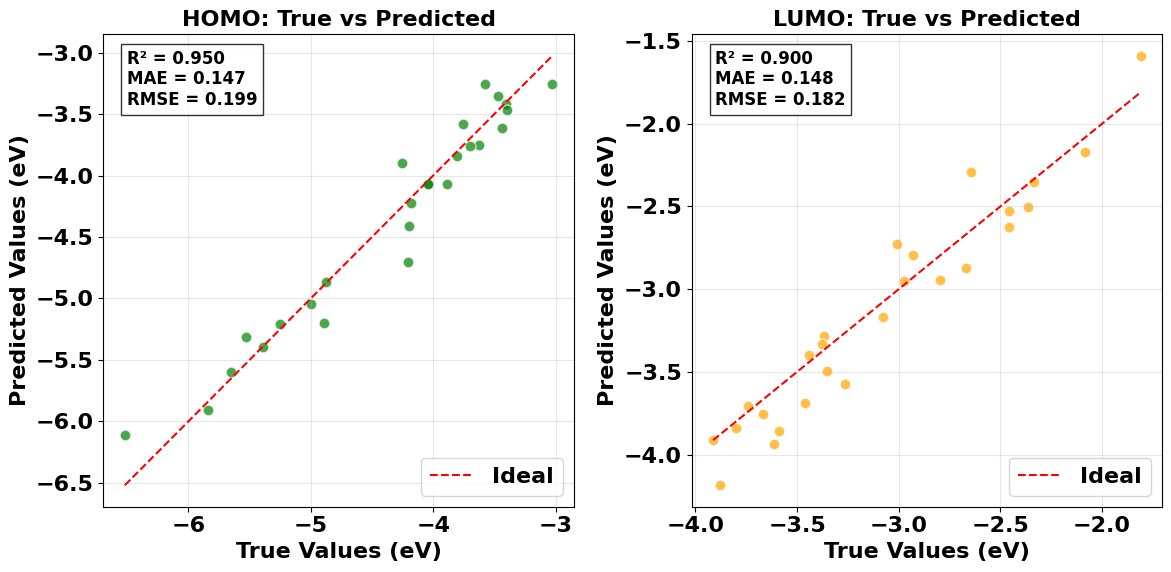


📊 Performance Summary:
HOMO: R²=0.9502, MAE=0.1471, RMSE=0.1992
LUMO: R²=0.9003, MAE=0.1483, RMSE=0.1823


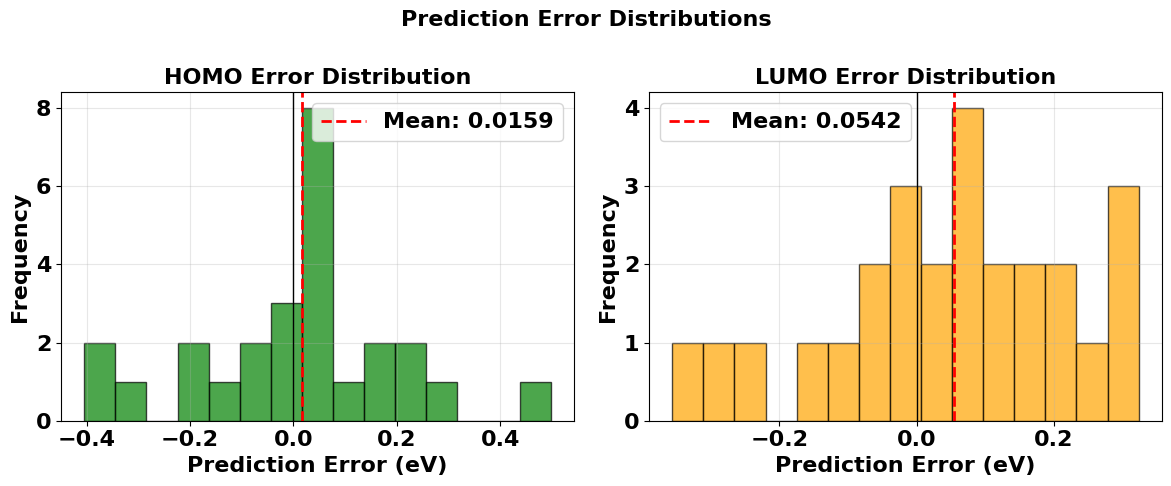

In [ ]:
# Step 3: Evaluate, Plot & Save Results
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Get predictions
test_preds = trainer.predict(mpnn, test_loader)
preds = torch.cat(test_preds, dim=0).numpy()
true_vals = ys_all[test_indices[0]]  # Shape: (N, 2) for [homo, lumo]
test_smiles = [smis[i] for i in test_indices[0]]
test_names = [names[i] for i in test_indices[0]]

# Create results DataFrame — ONLY homo and lumo
results_df = pd.DataFrame({
    'Name': test_names,
    'SMILES': test_smiles,
    'True_homo': true_vals[:, 0], 'Pred_homo': preds[:, 0],
    'True_lumo': true_vals[:, 1], 'Pred_lumo': preds[:, 1]
})

# Add error columns for homo and lumo only
for tgt in ['homo', 'lumo']:
    results_df[f'Error_{tgt}'] = (results_df[f'True_{tgt}'] - results_df[f'Pred_{tgt}']).abs()
    results_df[f'Pct_Error_{tgt}'] = (results_df[f'Error_{tgt}'] / (results_df[f'True_{tgt}'] + 1e-8)) * 100
    results_df[f'Signed_Error_{tgt}'] = results_df[f'True_{tgt}'] - results_df[f'Pred_{tgt}']

# Save to CSV
results_df.to_csv('test_set_predictions_with_name.csv', index=False)
print("✅ Predictions saved to 'test_set_predictions_with_name.csv'")

# Plotting: True vs Predicted — ONLY homo and lumo
targets = ['homo', 'lumo']
colors = ['green', 'orange']
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for i, tgt in enumerate(targets):
    t = results_df[f'True_{tgt}']
    p = results_df[f'Pred_{tgt}']
    r2 = r2_score(t, p)
    mae = mean_absolute_error(t, p)
    rmse = np.sqrt(mean_squared_error(t, p))

    axes[i].scatter(t, p, alpha=0.7, edgecolors='w', s=60, color=colors[i])
    axes[i].plot([t.min(), t.max()], [t.min(), t.max()], 'r--', label='Ideal')
    axes[i].text(0.05, 0.85, f'R² = {r2:.3f}\nMAE = {mae:.3f}\nRMSE = {rmse:.3f}',
                 transform=axes[i].transAxes, fontsize=12, weight='bold',
                 bbox=dict(facecolor='white', alpha=0.8))
    axes[i].set_xlabel('True Values (eV)')
    axes[i].set_ylabel('Predicted Values (eV)')
    axes[i].set_title(f'{tgt.upper()}: True vs Predicted')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Final metrics — ONLY homo and lumo
print("\n📊 Performance Summary:")
for tgt in ['homo', 'lumo']:
    t = results_df[f'True_{tgt}']
    p = results_df[f'Pred_{tgt}']
    r2 = r2_score(t, p)
    mae = mean_absolute_error(t, p)
    rmse = np.sqrt(mean_squared_error(t, p))
    print(f"{tgt.upper()}: R²={r2:.4f}, MAE={mae:.4f}, RMSE={rmse:.4f}")

# >>>>>>>>>>>>>>>>>> Error Distribution Plots <<<<<<<<<<<<<<<<<<<<
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, (target, color) in enumerate(zip(['homo', 'lumo'], ['green', 'orange'])):
    errors = results_df[f'Signed_Error_{target}']
    axes[i].hist(errors, bins=15, alpha=0.7, color=color, edgecolor='black')
    axes[i].axvline(x=errors.mean(), color='red', linestyle='--', linewidth=2,
                    label=f'Mean: {errors.mean():.4f}')
    axes[i].axvline(x=0, color='black', linestyle='-', linewidth=1)
    axes[i].set_xlabel('Prediction Error (eV)')
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'{target.upper()} Error Distribution')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Prediction Error Distributions', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()
# >>>>>>>>>>>>>>>>>> END <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

# >>>>>>>>>>>>>>>>>> UNIFORM BOLD FONT SETUP <<<<<<<<<<<<<<<<<<<<
plt.rcParams.update({
    'font.size': 16,
    'font.weight': 'bold',
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'legend.fontsize': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'axes.titlesize': 16,
    'figure.titlesize': 18
})
# >>>>>>>>>>>>>>>>>> END FONT SETUP <<<<<<<<<<<<<<<<<<<<<<<<<<<<

## Table of perdicted VS actual Targets

In [ ]:
# Create a table for representative quantum dots (EHOMO and ELUMO only)
print("\n📊 Table of True vs Predicted Values for Representative Quantum Dots:")
table_data = []

# Select 10 random rows from the results DataFrame
representative_samples = results_df.sample(n=10, random_state=42)  # Changed to n=10 as originally intended

# Extract relevant data for the table (only homo and lumo)
for _, row in representative_samples.iterrows():
    name = row['Name']
    true_homo, true_lumo = row['True_homo'], row['True_lumo']
    pred_homo, pred_lumo = row['Pred_homo'], row['Pred_lumo']
    error_homo = abs(true_homo - pred_homo)
    error_lumo = abs(true_lumo - pred_lumo)

    table_data.append([
        name,
        true_homo, true_lumo,
        pred_homo, pred_lumo,
        error_homo, error_lumo
    ])

# Define columns without any gap-related terms
table_columns = [
    "Name",
    "True EHOMO", "True ELUMO",
    "Pred EHOMO", "Pred ELUMO",
    "Error EHOMO", "Error ELUMO"
]

table_df = pd.DataFrame(table_data, columns=table_columns)

# Display the table
print(table_df.to_string(index=False))

# Save the table to a CSV file
table_df.to_csv("representative_predictions_table.csv", index=False)
print("\n✅ Table saved to 'representative_predictions_table.csv'")


📊 Table of True vs Predicted Values for Representative Quantum Dots:
                             Name  True EHOMO  True ELUMO  Pred EHOMO  Pred ELUMO  Error EHOMO  Error ELUMO
         141-NR_C0-2COOH-edge.pdb   -5.532813   -2.799468   -5.312693   -2.943500     0.220120     0.144032
             212-NR_SiC0-C_2S.pdb   -3.398926   -2.645998   -3.470942   -2.290306     0.072016     0.355692
               82-AH_NR3_4-2S.pdb   -3.407361   -3.007904   -3.421600   -2.726910     0.014239     0.280994
173-ZH_C-SMALL-2COH-poH2-edge.pdb   -6.520000   -3.666100   -6.115088   -3.755702     0.404912     0.089602
          71-AHSiC-2COOH-surf.pdb   -4.200018   -3.265864   -4.410497   -3.570926     0.210479     0.305061
           89-ZH_SIC-SMALL-2S.pdb   -3.760288   -2.456881   -3.577735   -2.526921     0.182553     0.070040
             37-ZH_C-SMALL-2S.pdb   -3.573076   -1.810348   -3.255712   -1.589563     0.317365     0.220785
                239-AHSiC-4NO.pdb   -5.839200   -3.615500   -5.908